# Encoder-Decoder

This is a skeleton notebook with only the structure for encoder and decoder. There is no input dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
# download the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

## VGG 16 Encoder

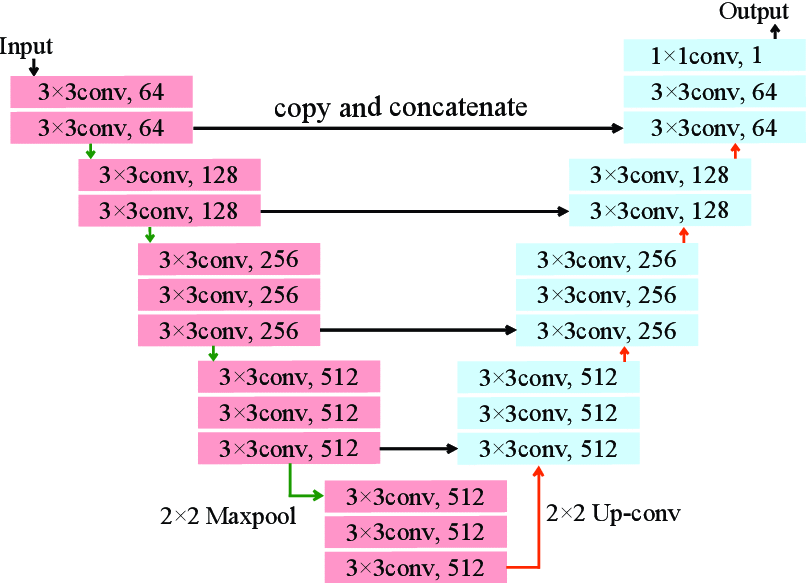

In [ ]:
def VGG_16(image_input):
  '''
  This function defines the VGG encoder.

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''
  # create 5 blocks with increasing filters at each stage.
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.

  x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',
                name='block1_conv1')(image_input)
  x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',
                name='block1_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                      )(x)
  p1 = x

  # Block 2
  x = Conv2D(filters= 128, kernel_size=(3, 3), activation='relu', padding='same',
              name='block2_conv1')(x)
  x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same',
              name='block2_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
  p2 = x

  # Block 3
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same',
              name='block3_conv1')(x)
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same',
              name='block3_conv2')(x)
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same',
              name='block3_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
  p3 = x

  # Block 4
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block4_conv1')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block4_conv2')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block4_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
  p4 = x

  # Block 5
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block5_conv1')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block5_conv2')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same',
              name='block5_conv3')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path)

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)


## FCN-8 Decoder

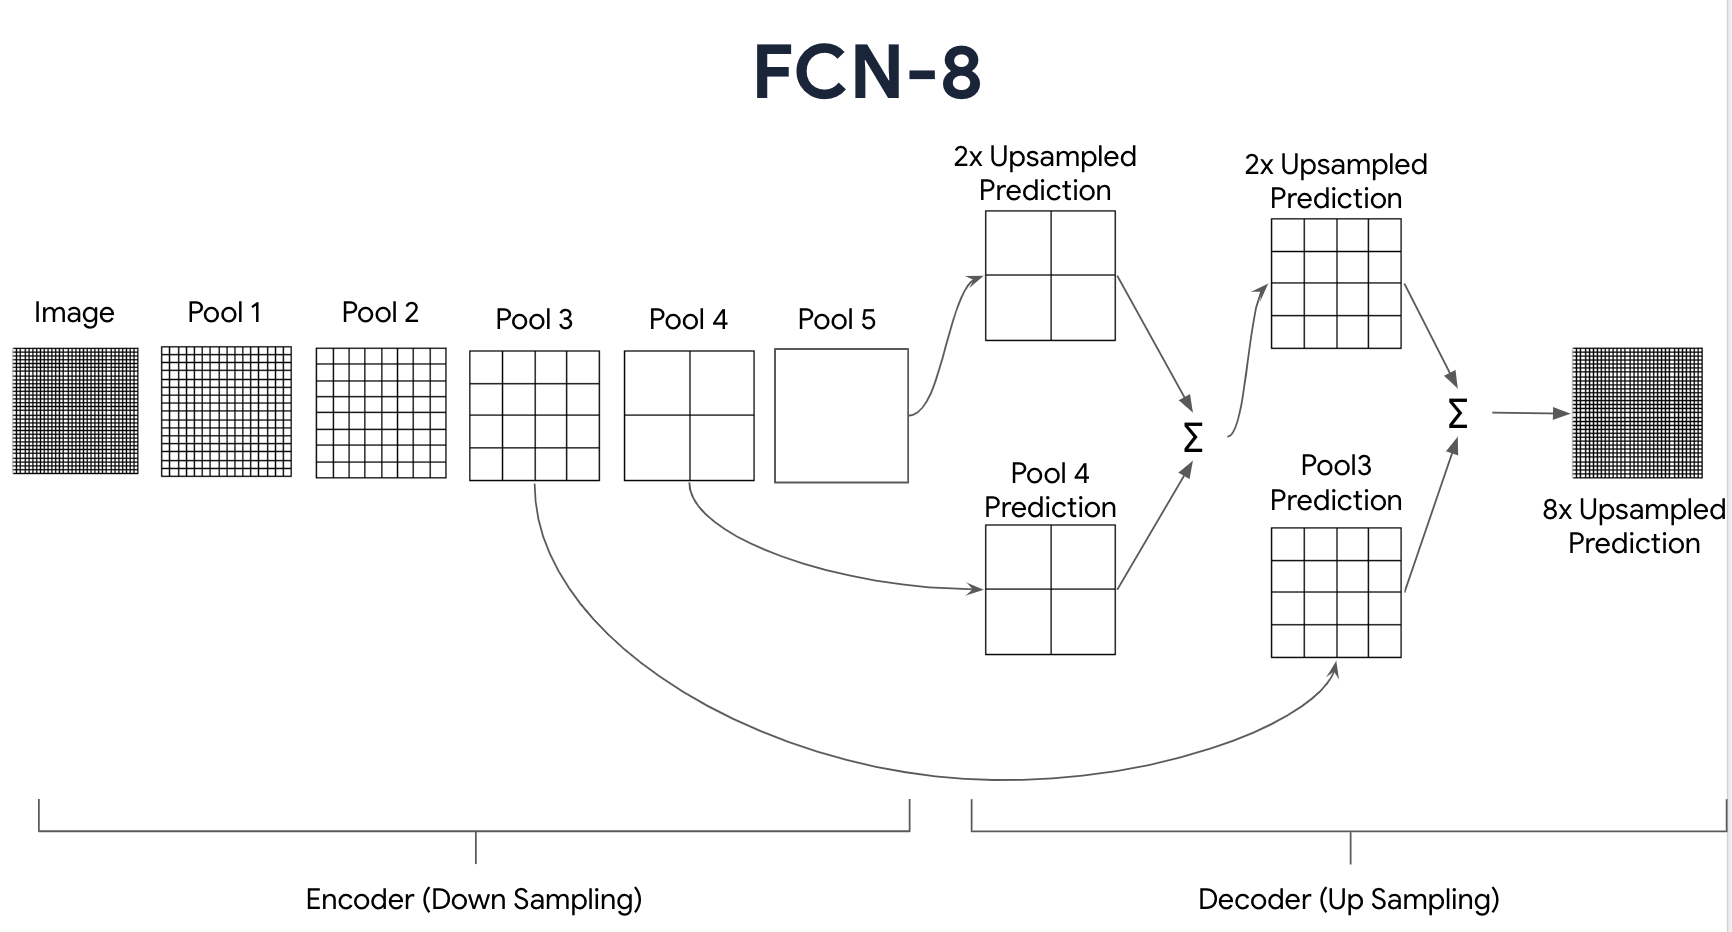

In [ ]:
def fcn8_decoder(convs, n_classes):
  '''
  Defines the FCN 8 decoder.

  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs

  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [ ]:
def segmentation_model():
  '''
  Defines the final segmentation model by chaining together the encoder and decoder.

  Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
  '''

  inputs = tf.keras.layers.Input(shape=(224,224,3,))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 12)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


In [ ]:
# instantiate the model and see how it looks
model = segmentation_model()
model.summary()